# Progressive Resizing
 
This is the notebook associated with the progressive resizing method in training.

## Imports

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

## Data

In [0]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/progressiveResizing_model.py" .
  import progressiveResizing_model
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"
  from resnet_autoencoder_training import progressiveResizing_model

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

def get_data(size):
  batchsize = 128
  #tfms = get_transforms(do_flip = True)
  tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
  src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
  data = (src.transform(tfms, size=size, tfm_y=True)
          .databunch(bs=batchsize)
          .normalize(imagenet_stats, do_y = False))
  return data

## Model

In [0]:
autoencoder = progressiveResizing_model.autoencoder([2,1])

### 16 by 16

In [0]:
learn = Learner(get_data(16), autoencoder, loss_func = F.mse_loss)

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.015901,0.011658,01:28
1,0.006453,0.005666,01:27
2,0.004652,0.005776,01:27
3,0.003630,0.003323,01:28
4,0.003224,0.002944,01:28


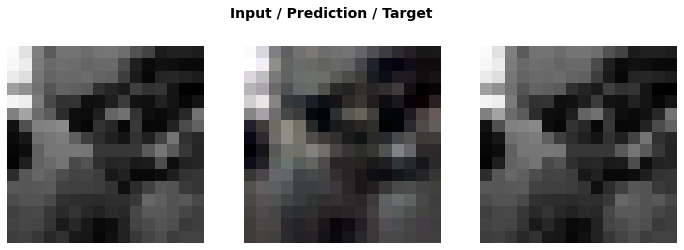

In [0]:
learn.show_results(rows = 1)

### 32 by 32

In [0]:
learn.data = get_data(32)

In [0]:
learn.model.decoder.up2.upsample = nn.Upsample(scale_factor=2.0, mode='nearest')

In [0]:
learn.model.decoder.up2.upsample

Upsample(scale_factor=2.0, mode=nearest)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 6.92E-05


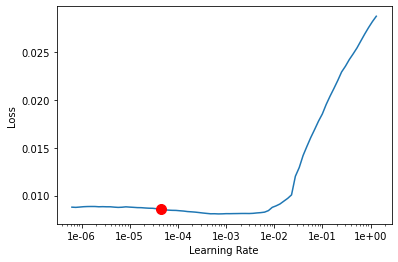

In [0]:
learn.recorder.plot(suggestion = True)

In [0]:
learn.metrics = [mean_squared_error, mean_absolute_error, r2_score, explained_variance]

In [0]:
learn.fit_one_cycle(10, max_lr = 1e-03)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time
0,0.004514,0.005890,0.005890,0.054960,0.903957,0.904635,01:34
1,0.004043,0.005436,0.005436,0.052718,0.911341,0.912747,01:34
2,0.004052,0.005193,0.005193,0.051535,0.915284,0.915428,01:35
3,0.003798,0.004981,0.004981,0.050240,0.918718,0.918934,01:34
4,0.003616,0.004822,0.004822,0.049387,0.921300,0.921467,01:35
5,0.003367,0.004848,0.004848,0.050348,0.920846,0.922136,01:35
6,0.003259,0.004534,0.004534,0.047678,0.925990,0.926986,01:35
7,0.003186,0.004429,0.004429,0.046995,0.927707,0.928631,01:35
8,0.003081,0.004312,0.004312,0.046160,0.929615,0.929625,01:35
9,0.003051,0.004310,0.004310,0.046132,0.929657,0.929784,01:35


## Results

### Training

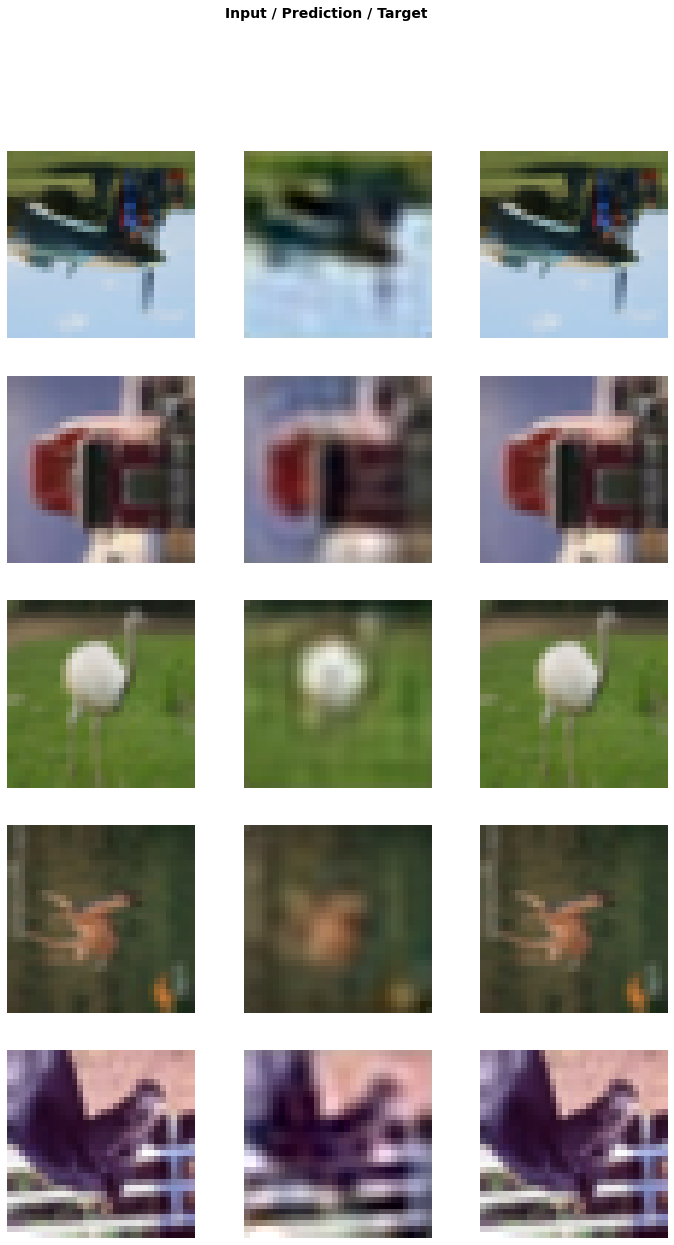

In [0]:
learn.show_results(ds_type=DatasetType.Train)

### Validation

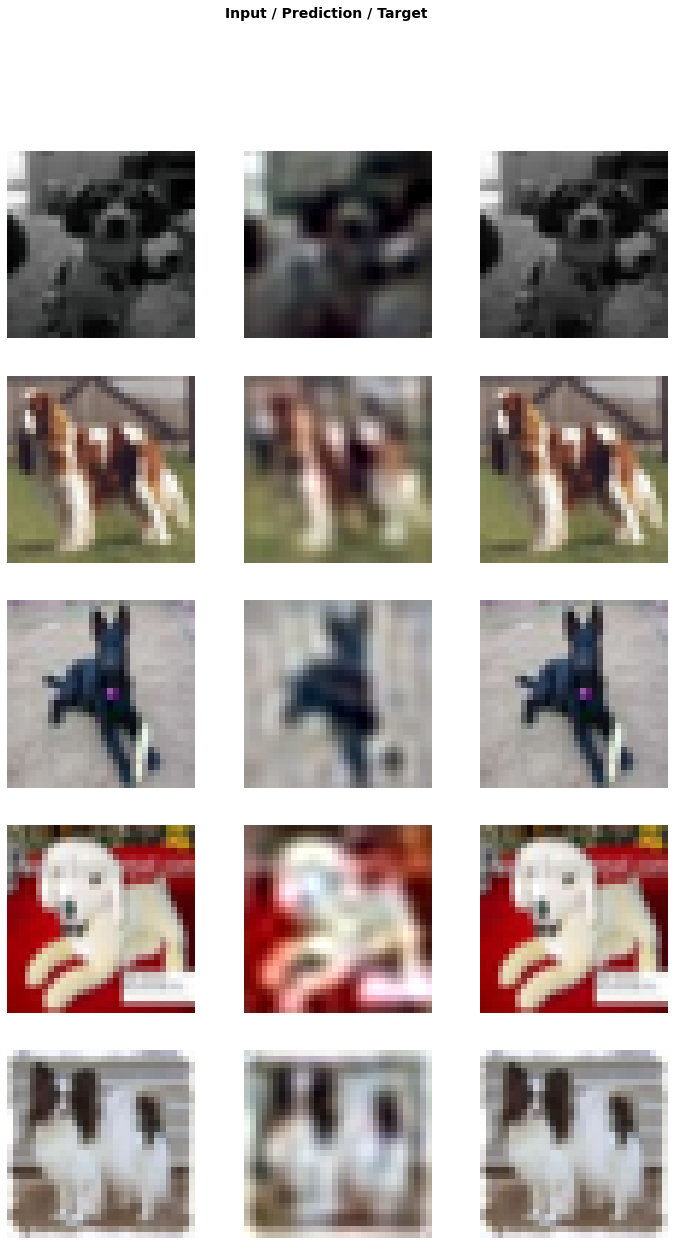

In [0]:
learn.show_results(ds_type=DatasetType.Valid)

In [0]:
torch.save(autoencoder, "/content/drive/My Drive/autoencoder-training/progResizing-Cifar10.pt")